In [1]:
import os
from scipy.io import loadmat
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Ridge  
from sklearn.linear_model import Lasso  
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
np.set_printoptions(precision=2, suppress=True)

In [2]:
#Variables et dimesionnalité
nb_AD = 28
nb_MCI = 22
nb_SCI = 22
Freqs= ['ALPHA', 'BETA', 'DELTA', 'THETA']
Seuils = [100, 70, 50, 30, 20, 10]
#dataFolder = '/home/houdahassini/Bureau/etude de cas2/EpEn data/EpEn data/'
dataFolder = 'EpEn data/'

In [3]:
#Chargement des matricces des trois types des patients
x_AD = []
for i in range(1, nb_AD+1):
    x = {}
    for freq in Freqs:
        x[freq + '_100'] = loadmat(dataFolder + freq + '/' 
                                    + 'AD' + '/' 
                                    + str(i) + '.mat')[freq]
    x_AD.append(x)

x_MCI = []
for i in range(1, nb_MCI+1):
    x = {}
    for freq in Freqs:
        x[freq + '_100'] = loadmat(dataFolder + freq + '/' 
                                    + 'MCI' + '/' 
                                    + str(i) + '.mat')[freq]
    x_MCI.append(x)

x_SCI= []
for i in range(1, nb_SCI+1):
    x = {}
    for freq in Freqs:
        x[freq + '_100'] = loadmat(dataFolder + freq + '/' 
                                    + 'SCI' + '/' 
                                    + str(i) + '.mat')[freq]
    x_SCI.append(x)

In [4]:
#On étend les dictionaires aux 6 différents niveau de seuil
def get_percentile(x, seuil):
    y = x.copy()
    percentile_limit = np.percentile(x, 100 - seuil)
    y[y<percentile_limit] = 0
    return y


for i in range(nb_AD):
    for freq in Freqs:
        for seuil in Seuils:
            x_AD[i][freq+'_'+str(seuil)] = get_percentile(x_AD[i][str(freq)+'_100'], seuil)
            
for i in range(nb_MCI):
    for freq in Freqs:
        for seuil in Seuils:
            x_MCI[i][freq+'_'+str(seuil)] = get_percentile(x_MCI[i][str(freq)+'_100'], seuil)
            
for i in range(nb_SCI):
    for freq in Freqs:
        for seuil in Seuils:
            x_SCI[i][freq+'_'+str(seuil)] = get_percentile(x_SCI[i][str(freq)+'_100'], seuil)

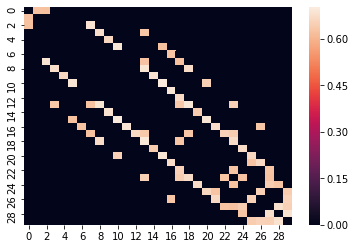

In [5]:
sns.heatmap(x_AD[27]['ALPHA_10'])

In [6]:
def nb_connexions_electrode(array):
    connexions = []
    for i in range(array.shape[0]):
        connexion = 0
        for j in range(len(connexions)):
            if array[i, j]>0:
                connexion += 1
        connexions.append(connexion)
    return connexions


def variance_cdf(array):
    variance_list = []
    for i in range(array.shape[0]):
        cdf = np.cumsum(array[i, :])
        variance_list.append(np.var(cdf))
    return variance_list

def moyenne(array):
    moyennes = []
    for i in range(array.shape[0]):
        moyenne = array[i, :].mean()
        moyennes.append(moyenne)
    return moyennes


In [7]:
Var=[]
for freq in Freqs:
    for seuil in Seuils:
        Var.append(freq+'_'+str(seuil))

In [8]:
matrices_AD = {}
for var in Var:
    matrice=[]
    for i in range (len(x_AD)):
        t = variance_cdf(x_AD[i][var])
        matrice.append(t)
    matrices_AD[var]= matrice
    
matrices_MCI = {}
for var in Var:
    matrice=[]
    for i in range (len(x_MCI)):
        t = variance_cdf(x_MCI[i][var])
        matrice.append(t)
    matrices_MCI[var]= matrice
    

matrices_SCI = {}
for var in Var:
    matrice=[]
    for i in range (len(x_SCI)):
        t = variance_cdf(x_SCI[i][var])
        matrice.append(t)
    matrices_SCI[var]= matrice

In [9]:
Elec = ['Elec1', 'Elec2', 'Elec3', 'Elec4', 'Elec5', 'Elec6', 'Elec7', 'Elec8', 'Elec9', 'Elec10', 'Elec11', 'Elec12', 'Elec13', 'Elec14', 'Elec15', 'Elec16', 'Elec17', 'Elec18', 'Elec19', 'Elec20', 'Elec21', 'Elec22', 'Elec23', 'Elec24', 'Elec25', 'Elec26', 'Elec27', 'Elec28', 'Elec29', 'Elec30']

In [10]:
def dataframe_creator(array,names):
    x = pd.DataFrame(array,columns=names)
    return x


In [11]:
data_AD_ALPHA_100= dataframe_creator(matrices_AD['ALPHA_100'],Elec)
data_AD_ALPHA_70= dataframe_creator(matrices_AD['ALPHA_70'],Elec)
data_AD_ALPHA_50= dataframe_creator(matrices_AD['ALPHA_50'],Elec)
data_AD_ALPHA_30= dataframe_creator(matrices_AD['ALPHA_30'],Elec)
data_AD_ALPHA_20= dataframe_creator(matrices_AD['ALPHA_20'],Elec)
data_AD_ALPHA_10= dataframe_creator(matrices_AD['ALPHA_10'],Elec)
data_AD_BETA_100= dataframe_creator(matrices_AD['BETA_100'],Elec)
data_AD_BETA_70= dataframe_creator(matrices_AD['BETA_70'],Elec)
data_AD_BETA_50= dataframe_creator(matrices_AD['BETA_50'],Elec)
data_AD_BETA_30= dataframe_creator(matrices_AD['BETA_30'],Elec)
data_AD_BETA_20= dataframe_creator(matrices_AD['BETA_20'],Elec)
data_AD_BETA_10= dataframe_creator(matrices_AD['BETA_10'],Elec)
data_AD_DELTA_100= dataframe_creator(matrices_AD['DELTA_100'],Elec)
data_AD_DELTA_70= dataframe_creator(matrices_AD['DELTA_70'],Elec)
data_AD_DELTA_50= dataframe_creator(matrices_AD['DELTA_50'],Elec)
data_AD_DELTA_30= dataframe_creator(matrices_AD['DELTA_30'],Elec)
data_AD_DELTA_20= dataframe_creator(matrices_AD['DELTA_20'],Elec)
data_AD_DELTA_10= dataframe_creator(matrices_AD['DELTA_10'],Elec)
data_AD_THETA_100= dataframe_creator(matrices_AD['THETA_100'],Elec)
data_AD_THETA_70= dataframe_creator(matrices_AD['THETA_70'],Elec)
data_AD_THETA_50= dataframe_creator(matrices_AD['THETA_50'],Elec)
data_AD_THETA_30= dataframe_creator(matrices_AD['THETA_30'],Elec)
data_AD_THETA_20= dataframe_creator(matrices_AD['THETA_20'],Elec)
data_AD_THETA_10= dataframe_creator(matrices_AD['THETA_10'],Elec)

In [12]:
data_MCI_ALPHA_100= dataframe_creator(matrices_MCI['ALPHA_100'],Elec)
data_MCI_ALPHA_70= dataframe_creator(matrices_MCI['ALPHA_70'],Elec)
data_MCI_ALPHA_50= dataframe_creator(matrices_MCI['ALPHA_50'],Elec)
data_MCI_ALPHA_30= dataframe_creator(matrices_MCI['ALPHA_30'],Elec)
data_MCI_ALPHA_20= dataframe_creator(matrices_MCI['ALPHA_20'],Elec)
data_MCI_ALPHA_10= dataframe_creator(matrices_MCI['ALPHA_10'],Elec)
data_MCI_BETA_100= dataframe_creator(matrices_MCI['BETA_100'],Elec)
data_MCI_BETA_70= dataframe_creator(matrices_MCI['BETA_70'],Elec)
data_MCI_BETA_50= dataframe_creator(matrices_MCI['BETA_50'],Elec)
data_MCI_BETA_30= dataframe_creator(matrices_MCI['BETA_30'],Elec)
data_MCI_BETA_20= dataframe_creator(matrices_MCI['BETA_20'],Elec)
data_MCI_BETA_10= dataframe_creator(matrices_MCI['BETA_10'],Elec)
data_MCI_DELTA_100= dataframe_creator(matrices_MCI['DELTA_100'],Elec)
data_MCI_DELTA_70= dataframe_creator(matrices_MCI['DELTA_70'],Elec)
data_MCI_DELTA_50= dataframe_creator(matrices_MCI['DELTA_50'],Elec)
data_MCI_DELTA_30= dataframe_creator(matrices_MCI['DELTA_30'],Elec)
data_MCI_DELTA_20= dataframe_creator(matrices_MCI['DELTA_20'],Elec)
data_MCI_DELTA_10= dataframe_creator(matrices_MCI['DELTA_10'],Elec)
data_MCI_THETA_100= dataframe_creator(matrices_MCI['THETA_100'],Elec)
data_MCI_THETA_70= dataframe_creator(matrices_MCI['THETA_70'],Elec)
data_MCI_THETA_50= dataframe_creator(matrices_MCI['THETA_50'],Elec)
data_MCI_THETA_30= dataframe_creator(matrices_MCI['THETA_30'],Elec)
data_MCI_THETA_20= dataframe_creator(matrices_MCI['THETA_20'],Elec)
data_MCI_THETA_10= dataframe_creator(matrices_MCI['THETA_10'],Elec)

In [13]:
data_SCI_ALPHA_100= dataframe_creator(matrices_SCI['ALPHA_100'],Elec)
data_SCI_ALPHA_70= dataframe_creator(matrices_SCI['ALPHA_70'],Elec)
data_SCI_ALPHA_50= dataframe_creator(matrices_SCI['ALPHA_50'],Elec)
data_SCI_ALPHA_30= dataframe_creator(matrices_SCI['ALPHA_30'],Elec)
data_SCI_ALPHA_20= dataframe_creator(matrices_SCI['ALPHA_20'],Elec)
data_SCI_ALPHA_10= dataframe_creator(matrices_SCI['ALPHA_10'],Elec)
data_SCI_BETA_100= dataframe_creator(matrices_SCI['BETA_100'],Elec)
data_SCI_BETA_70= dataframe_creator(matrices_SCI['BETA_70'],Elec)
data_SCI_BETA_50= dataframe_creator(matrices_SCI['BETA_50'],Elec)
data_SCI_BETA_30= dataframe_creator(matrices_SCI['BETA_30'],Elec)
data_SCI_BETA_20= dataframe_creator(matrices_SCI['BETA_20'],Elec)
data_SCI_BETA_10= dataframe_creator(matrices_SCI['BETA_10'],Elec)
data_SCI_DELTA_100= dataframe_creator(matrices_SCI['DELTA_100'],Elec)
data_SCI_DELTA_70= dataframe_creator(matrices_SCI['DELTA_70'],Elec)
data_SCI_DELTA_50= dataframe_creator(matrices_SCI['DELTA_50'],Elec)
data_SCI_DELTA_30= dataframe_creator(matrices_SCI['DELTA_30'],Elec)
data_SCI_DELTA_20= dataframe_creator(matrices_SCI['DELTA_20'],Elec)
data_SCI_DELTA_10= dataframe_creator(matrices_SCI['DELTA_10'],Elec)
data_SCI_THETA_100= dataframe_creator(matrices_SCI['THETA_100'],Elec)
data_SCI_THETA_70= dataframe_creator(matrices_SCI['THETA_70'],Elec)
data_SCI_THETA_50= dataframe_creator(matrices_SCI['THETA_50'],Elec)
data_SCI_THETA_30= dataframe_creator(matrices_SCI['THETA_30'],Elec)
data_SCI_THETA_20= dataframe_creator(matrices_SCI['THETA_20'],Elec)
data_SCI_THETA_10= dataframe_creator(matrices_SCI['THETA_10'],Elec)

In [14]:
#datasets AD vs MCI
data_AD_MCI_ALPHA_100= pd.concat([data_AD_ALPHA_100,data_MCI_ALPHA_100])
data_AD_MCI_ALPHA_70= pd.concat([data_AD_ALPHA_70,data_MCI_ALPHA_70])
data_AD_MCI_ALPHA_50= pd.concat([data_AD_ALPHA_50,data_MCI_ALPHA_50])
data_AD_MCI_ALPHA_30= pd.concat([data_AD_ALPHA_30,data_MCI_ALPHA_30])
data_AD_MCI_ALPHA_20= pd.concat([data_AD_ALPHA_20,data_MCI_ALPHA_20])
data_AD_MCI_ALPHA_10= pd.concat([data_AD_ALPHA_10,data_MCI_ALPHA_10])
data_AD_MCI_BETA_100= pd.concat([data_AD_BETA_100,data_MCI_BETA_100])
data_AD_MCI_BETA_70= pd.concat([data_AD_BETA_70,data_MCI_BETA_70])
data_AD_MCI_BETA_50= pd.concat([data_AD_BETA_50,data_MCI_BETA_50])
data_AD_MCI_BETA_30= pd.concat([data_AD_BETA_30,data_MCI_BETA_30])
data_AD_MCI_BETA_20= pd.concat([data_AD_BETA_20,data_MCI_BETA_20])
data_AD_MCI_BETA_10= pd.concat([data_AD_BETA_10,data_MCI_BETA_10])
data_AD_MCI_DELTA_100= pd.concat([data_AD_DELTA_100,data_MCI_DELTA_100])
data_AD_MCI_DELTA_70= pd.concat([data_AD_DELTA_70,data_MCI_DELTA_70])
data_AD_MCI_DELTA_50= pd.concat([data_AD_DELTA_50,data_MCI_DELTA_50])
data_AD_MCI_DELTA_30= pd.concat([data_AD_DELTA_30,data_MCI_DELTA_30])
data_AD_MCI_DELTA_20= pd.concat([data_AD_DELTA_20,data_MCI_DELTA_20])
data_AD_MCI_DELTA_10= pd.concat([data_AD_DELTA_10,data_MCI_DELTA_10])
data_AD_MCI_THETA_100= pd.concat([data_AD_THETA_100,data_MCI_THETA_100])
data_AD_MCI_THETA_70= pd.concat([data_AD_THETA_70,data_MCI_THETA_70])
data_AD_MCI_THETA_50= pd.concat([data_AD_THETA_50,data_MCI_THETA_50])
data_AD_MCI_THETA_30= pd.concat([data_AD_THETA_30,data_MCI_THETA_30])
data_AD_MCI_THETA_20= pd.concat([data_AD_THETA_20,data_MCI_THETA_20])
data_AD_MCI_THETA_10= pd.concat([data_AD_THETA_10,data_MCI_THETA_10])

In [15]:
#datasets SCI vs MCI
data_SCI_MCI_ALPHA_100= pd.concat([data_SCI_ALPHA_100,data_MCI_ALPHA_100])
data_SCI_MCI_ALPHA_70= pd.concat([data_SCI_ALPHA_70,data_MCI_ALPHA_70])
data_SCI_MCI_ALPHA_50= pd.concat([data_SCI_ALPHA_50,data_MCI_ALPHA_50])
data_SCI_MCI_ALPHA_30= pd.concat([data_SCI_ALPHA_30,data_MCI_ALPHA_30])
data_SCI_MCI_ALPHA_20= pd.concat([data_SCI_ALPHA_20,data_MCI_ALPHA_20])
data_SCI_MCI_ALPHA_10= pd.concat([data_SCI_ALPHA_10,data_MCI_ALPHA_10])
data_SCI_MCI_BETA_100= pd.concat([data_SCI_BETA_100,data_MCI_BETA_100])
data_SCI_MCI_BETA_70= pd.concat([data_SCI_BETA_70,data_MCI_BETA_70])
data_SCI_MCI_BETA_50= pd.concat([data_SCI_BETA_50,data_MCI_BETA_50])
data_SCI_MCI_BETA_30= pd.concat([data_SCI_BETA_30,data_MCI_BETA_30])
data_SCI_MCI_BETA_20= pd.concat([data_SCI_BETA_20,data_MCI_BETA_20])
data_SCI_MCI_BETA_10= pd.concat([data_SCI_BETA_10,data_MCI_BETA_10])
data_SCI_MCI_DELTA_100= pd.concat([data_SCI_DELTA_100,data_MCI_DELTA_100])
data_SCI_MCI_DELTA_70= pd.concat([data_SCI_DELTA_70,data_MCI_DELTA_70])
data_SCI_MCI_DELTA_50= pd.concat([data_SCI_DELTA_50,data_MCI_DELTA_50])
data_SCI_MCI_DELTA_30= pd.concat([data_SCI_DELTA_30,data_MCI_DELTA_30])
data_SCI_MCI_DELTA_20= pd.concat([data_SCI_DELTA_20,data_MCI_DELTA_20])
data_SCI_MCI_DELTA_10= pd.concat([data_SCI_DELTA_10,data_MCI_DELTA_10])
data_SCI_MCI_THETA_100= pd.concat([data_SCI_THETA_100,data_MCI_THETA_100])
data_SCI_MCI_THETA_70= pd.concat([data_SCI_THETA_70,data_MCI_THETA_70])
data_SCI_MCI_THETA_50= pd.concat([data_SCI_THETA_50,data_MCI_THETA_50])
data_SCI_MCI_THETA_30= pd.concat([data_SCI_THETA_30,data_MCI_THETA_30])
data_SCI_MCI_THETA_20= pd.concat([data_SCI_THETA_20,data_MCI_THETA_20])
data_SCI_MCI_THETA_10= pd.concat([data_SCI_THETA_10,data_MCI_THETA_10])

In [16]:
#datasets SCI vs AD
data_SCI_AD_ALPHA_100= pd.concat([data_SCI_ALPHA_100,data_AD_ALPHA_100])
data_SCI_AD_ALPHA_70= pd.concat([data_SCI_ALPHA_70,data_AD_ALPHA_70])
data_SCI_AD_ALPHA_50= pd.concat([data_SCI_ALPHA_50,data_AD_ALPHA_50])
data_SCI_AD_ALPHA_30= pd.concat([data_SCI_ALPHA_30,data_AD_ALPHA_30])
data_SCI_AD_ALPHA_20= pd.concat([data_SCI_ALPHA_20,data_AD_ALPHA_20])
data_SCI_AD_ALPHA_10= pd.concat([data_SCI_ALPHA_10,data_AD_ALPHA_10])
data_SCI_AD_BETA_100= pd.concat([data_SCI_BETA_100,data_AD_BETA_100])
data_SCI_AD_BETA_70= pd.concat([data_SCI_BETA_70,data_AD_BETA_70])
data_SCI_AD_BETA_50= pd.concat([data_SCI_BETA_50,data_AD_BETA_50])
data_SCI_AD_BETA_30= pd.concat([data_SCI_BETA_30,data_AD_BETA_30])
data_SCI_AD_BETA_20= pd.concat([data_SCI_BETA_20,data_AD_BETA_20])
data_SCI_AD_BETA_10= pd.concat([data_SCI_BETA_10,data_AD_BETA_10])
data_SCI_AD_DELTA_100= pd.concat([data_SCI_DELTA_100,data_AD_DELTA_100])
data_SCI_AD_DELTA_70= pd.concat([data_SCI_DELTA_70,data_AD_DELTA_70])
data_SCI_AD_DELTA_50= pd.concat([data_SCI_DELTA_50,data_AD_DELTA_50])
data_SCI_AD_DELTA_30= pd.concat([data_SCI_DELTA_30,data_AD_DELTA_30])
data_SCI_AD_DELTA_20= pd.concat([data_SCI_DELTA_20,data_AD_DELTA_20])
data_SCI_AD_DELTA_10= pd.concat([data_SCI_DELTA_10,data_AD_DELTA_10])
data_SCI_AD_THETA_100= pd.concat([data_SCI_THETA_100,data_AD_THETA_100])
data_SCI_AD_THETA_70= pd.concat([data_SCI_THETA_70,data_AD_THETA_70])
data_SCI_AD_THETA_50= pd.concat([data_SCI_THETA_50,data_AD_THETA_50])
data_SCI_AD_THETA_30= pd.concat([data_SCI_THETA_30,data_AD_THETA_30])
data_SCI_AD_THETA_20= pd.concat([data_SCI_THETA_20,data_AD_THETA_20])
data_SCI_AD_THETA_10= pd.concat([data_SCI_THETA_10,data_AD_THETA_10])

In [17]:
#Dataset split
y=[0]*28+[1]*22

In [18]:
## Sélaction 1 : AD vs MCI
model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_AD_MCI_ALPHA_100, y)
variable1 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_AD_MCI_ALPHA_70, y)
variable2 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_AD_MCI_ALPHA_50, y)
variable3 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_AD_MCI_ALPHA_30, y)
variable4 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_AD_MCI_ALPHA_20, y)
variable5 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_AD_MCI_ALPHA_10, y)
variable6 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_AD_MCI_BETA_100, y)
variable7 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_AD_MCI_BETA_70, y)
variable8 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_AD_MCI_BETA_50, y)
variable9 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_AD_MCI_BETA_30, y)
variable10 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_AD_MCI_BETA_20, y)
variable11 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_AD_MCI_BETA_10, y)
variable12 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_AD_MCI_DELTA_100, y)
variable13 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_AD_MCI_DELTA_70, y)
variable14 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_AD_MCI_DELTA_50, y)
variable15 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_AD_MCI_DELTA_30, y)
variable16 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_AD_MCI_DELTA_20, y)
variable17 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_AD_MCI_DELTA_10, y)
variable18 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_AD_MCI_THETA_100, y)
variable19 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_AD_MCI_THETA_70, y)
variable20 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_AD_MCI_THETA_50, y)
variable21 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_AD_MCI_THETA_30, y)
variable22 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_AD_MCI_THETA_20, y)
variable23 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_AD_MCI_THETA_10, y)
variable24 = model.feature_importances_

In [19]:
variable1=variable1.tolist()
variable2=variable2.tolist()
variable3=variable3.tolist()
variable4=variable4.tolist()
variable5=variable5.tolist()
variable6=variable6.tolist()
variable7=variable7.tolist()
variable8=variable8.tolist()
variable9=variable9.tolist()
variable10=variable10.tolist()
variable11=variable11.tolist()
variable12=variable12.tolist()
variable13=variable13.tolist()
variable14=variable14.tolist()
variable15=variable15.tolist()
variable16=variable16.tolist()
variable17=variable17.tolist()
variable18=variable18.tolist()
variable19=variable19.tolist()
variable20=variable20.tolist()
variable21=variable21.tolist()
variable22=variable22.tolist()
variable23=variable23.tolist()
variable24=variable24.tolist()

In [20]:
data_col_names_AD_MCI = ['ALPHA_100_'+Elec[variable1.index(max(variable1))],
                  'ALPHA_70_'+Elec[variable2.index(max(variable2))],
                  'ALPHA_50_'+Elec[variable3.index(max(variable3))],
                  'ALPHA_30_'+Elec[variable4.index(max(variable4))],
                  'ALPHA_20_'+Elec[variable5.index(max(variable5))],
                  'ALPHA_10_'+Elec[variable6.index(max(variable6))],
                  'BETA_100_'+Elec[variable7.index(max(variable7))],
                  'BETA_70_'+Elec[variable8.index(max(variable8))],
                  'BETA_50_'+Elec[variable9.index(max(variable9))],
                  'BETA_30_'+Elec[variable10.index(max(variable10))],
                  'BETA_20_'+Elec[variable11.index(max(variable11))],
                  'BETA_10_'+Elec[variable12.index(max(variable12))],
                  'DELTA_100_'+Elec[variable13.index(max(variable13))],
                  'DELTA_70_'+Elec[variable14.index(max(variable14))],
                  'DELTA_50_'+Elec[variable15.index(max(variable15))],
                  'DELTA_30_'+Elec[variable16.index(max(variable16))],
                  'DELTA_20_'+Elec[variable17.index(max(variable17))],
                  'DELTA_10_'+Elec[variable18.index(max(variable18))],
                  'THETA_100_'+Elec[variable19.index(max(variable19))],
                  'THETA_70_'+Elec[variable20.index(max(variable20))],
                  'THETA_50_'+Elec[variable21.index(max(variable21))],
                  'THETA_30_'+Elec[variable22.index(max(variable22))],
                  'THETA_20_'+Elec[variable23.index(max(variable23))],
                  'THETA_10_'+Elec[variable24.index(max(variable24))]]                                                                                                                                                                                                                                                                                                                          

In [21]:
#Création dataset selection2 ad vs mci
dataset_AD_MCI_train= pd.concat([data_AD_MCI_ALPHA_100.iloc[:,variable1.index(max(variable1))], 
                                data_AD_MCI_ALPHA_70.iloc[:,variable2.index(max(variable2))],
                                data_AD_MCI_ALPHA_50.iloc[:,variable3.index(max(variable3))],
                                data_AD_MCI_ALPHA_30.iloc[:,variable4.index(max(variable4))], 
                                data_AD_MCI_ALPHA_20.iloc[:,variable5.index(max(variable5))],
                                data_AD_MCI_ALPHA_10.iloc[:,variable6.index(max(variable6))],
                                data_AD_MCI_BETA_100.iloc[:,variable7.index(max(variable7))],
                                data_AD_MCI_BETA_70.iloc[:,variable8.index(max(variable8))],
                                data_AD_MCI_BETA_50.iloc[:,variable9.index(max(variable9))],
                                data_AD_MCI_BETA_30.iloc[:,variable10.index(max(variable10))],
                                data_AD_MCI_BETA_20.iloc[:,variable11.index(max(variable11))],
                                data_AD_MCI_BETA_10.iloc[:,variable12.index(max(variable12))],
                                data_AD_MCI_DELTA_100.iloc[:,variable13.index(max(variable13))],
                                data_AD_MCI_DELTA_70.iloc[:,variable14.index(max(variable14))],
                                data_AD_MCI_DELTA_50.iloc[:,variable15.index(max(variable15))],
                                data_AD_MCI_DELTA_30.iloc[:,variable16.index(max(variable16))],
                                data_AD_MCI_DELTA_20.iloc[:,variable17.index(max(variable17))],
                                data_AD_MCI_DELTA_10.iloc[:,variable18.index(max(variable18))],
                                data_AD_MCI_THETA_100.iloc[:,variable19.index(max(variable19))],
                                data_AD_MCI_THETA_70.iloc[:,variable20.index(max(variable20))],
                                data_AD_MCI_THETA_50.iloc[:,variable21.index(max(variable21))],
                                data_AD_MCI_THETA_30.iloc[:,variable22.index(max(variable22))],
                                data_AD_MCI_THETA_20.iloc[:,variable23.index(max(variable23))],
                                data_AD_MCI_THETA_10.iloc[:,variable24.index(max(variable24))]],axis=1)
dataset_AD_MCI_train.columns = data_col_names_AD_MCI

In [22]:
#Dataset split
y=[0]*22+[1]*22

In [23]:
# Sélaction 1 : SCI vs MCI
model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_MCI_ALPHA_100, y)
variable1 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_MCI_ALPHA_70, y)
variable2 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_MCI_ALPHA_50, y)
variable3 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_MCI_ALPHA_30, y)
variable4 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_MCI_ALPHA_20, y)
variable5 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_MCI_ALPHA_10, y)
variable6 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_MCI_BETA_100, y)
variable7 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_MCI_BETA_70, y)
variable8 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_MCI_BETA_50, y)
variable9 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_MCI_BETA_30, y)
variable10 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_MCI_BETA_20, y)
variable11 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_MCI_BETA_10, y)
variable12 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_MCI_DELTA_100, y)
variable13 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_MCI_DELTA_70, y)
variable14 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_MCI_DELTA_50, y)
variable15 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_MCI_DELTA_30, y)
variable16 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_MCI_DELTA_20, y)
variable17 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_MCI_DELTA_10, y)
variable18 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_MCI_THETA_100, y)
variable19 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_MCI_THETA_70, y)
variable20 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_MCI_THETA_50, y)
variable21 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_MCI_THETA_30, y)
variable22 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_MCI_THETA_20, y)
variable23 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_MCI_THETA_10, y)
variable24 = model.feature_importances_

In [24]:
variable1=variable1.tolist()
variable2=variable2.tolist()
variable3=variable3.tolist()
variable4=variable4.tolist()
variable5=variable5.tolist()
variable6=variable6.tolist()
variable7=variable7.tolist()
variable8=variable8.tolist()
variable9=variable9.tolist()
variable10=variable10.tolist()
variable11=variable11.tolist()
variable12=variable12.tolist()
variable13=variable13.tolist()
variable14=variable14.tolist()
variable15=variable15.tolist()
variable16=variable16.tolist()
variable17=variable17.tolist()
variable18=variable18.tolist()
variable19=variable19.tolist()
variable20=variable20.tolist()
variable21=variable21.tolist()
variable22=variable22.tolist()
variable23=variable23.tolist()
variable24=variable24.tolist()

In [25]:
data_col_names_SCI_MCI = ['ALPHA_100_'+Elec[variable1.index(max(variable1))],
                  'ALPHA_70_'+Elec[variable2.index(max(variable2))],
                  'ALPHA_50_'+Elec[variable3.index(max(variable3))],
                  'ALPHA_30_'+Elec[variable4.index(max(variable4))],
                  'ALPHA_20_'+Elec[variable5.index(max(variable5))],
                  'ALPHA_10_'+Elec[variable6.index(max(variable6))],
                  'BETA_100_'+Elec[variable7.index(max(variable7))],
                  'BETA_70_'+Elec[variable8.index(max(variable8))],
                  'BETA_50_'+Elec[variable9.index(max(variable9))],
                  'BETA_30_'+Elec[variable10.index(max(variable10))],
                  'BETA_20_'+Elec[variable11.index(max(variable11))],
                  'BETA_10_'+Elec[variable12.index(max(variable12))],
                  'DELTA_100_'+Elec[variable13.index(max(variable13))],
                  'DELTA_70_'+Elec[variable14.index(max(variable14))],
                  'DELTA_50_'+Elec[variable15.index(max(variable15))],
                  'DELTA_30_'+Elec[variable16.index(max(variable16))],
                  'DELTA_20_'+Elec[variable17.index(max(variable17))],
                  'DELTA_10_'+Elec[variable18.index(max(variable18))],
                  'THETA_100_'+Elec[variable19.index(max(variable19))],
                  'THETA_70_'+Elec[variable20.index(max(variable20))],
                  'THETA_50_'+Elec[variable21.index(max(variable21))],
                  'THETA_30_'+Elec[variable22.index(max(variable22))],
                  'THETA_20_'+Elec[variable23.index(max(variable23))],
                  'THETA_10_'+Elec[variable24.index(max(variable24))]]                                                                                                                                                                 

In [26]:
#Création dataset selection2 SCI vs mci
dataset_SCI_MCI_train= pd.concat([data_SCI_MCI_ALPHA_100.iloc[:,variable1.index(max(variable1))], 
                                data_SCI_MCI_ALPHA_70.iloc[:,variable2.index(max(variable2))],
                                data_SCI_MCI_ALPHA_50.iloc[:,variable3.index(max(variable3))],
                                data_SCI_MCI_ALPHA_30.iloc[:,variable4.index(max(variable4))], 
                                data_SCI_MCI_ALPHA_20.iloc[:,variable5.index(max(variable5))],
                                data_SCI_MCI_ALPHA_10.iloc[:,variable6.index(max(variable6))],
                                data_SCI_MCI_BETA_100.iloc[:,variable7.index(max(variable7))],
                                data_SCI_MCI_BETA_70.iloc[:,variable8.index(max(variable8))],
                                data_SCI_MCI_BETA_50.iloc[:,variable9.index(max(variable9))],
                                data_SCI_MCI_BETA_30.iloc[:,variable10.index(max(variable10))],
                                data_SCI_MCI_BETA_20.iloc[:,variable11.index(max(variable11))],
                                data_SCI_MCI_BETA_10.iloc[:,variable12.index(max(variable12))],
                                data_SCI_MCI_DELTA_100.iloc[:,variable13.index(max(variable13))],
                                data_SCI_MCI_DELTA_70.iloc[:,variable14.index(max(variable14))],
                                data_SCI_MCI_DELTA_50.iloc[:,variable15.index(max(variable15))],
                                data_SCI_MCI_DELTA_30.iloc[:,variable16.index(max(variable16))],
                                data_SCI_MCI_DELTA_20.iloc[:,variable17.index(max(variable17))],
                                data_SCI_MCI_DELTA_10.iloc[:,variable18.index(max(variable18))],
                                data_SCI_MCI_THETA_100.iloc[:,variable19.index(max(variable19))],
                                data_SCI_MCI_THETA_70.iloc[:,variable20.index(max(variable20))],
                                data_SCI_MCI_THETA_50.iloc[:,variable21.index(max(variable21))],
                                data_SCI_MCI_THETA_30.iloc[:,variable22.index(max(variable22))],
                                data_SCI_MCI_THETA_20.iloc[:,variable23.index(max(variable23))],
                                data_SCI_MCI_THETA_10.iloc[:,variable24.index(max(variable24))]],axis=1)

dataset_SCI_MCI_train.columns = data_col_names_SCI_MCI

In [27]:
#Dataset split
y=[0]*22+[1]*28

In [29]:
# Sélaction 1 : SCI vs AD
model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_AD_ALPHA_100, y)
variable1 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_AD_ALPHA_70, y)
variable2 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_AD_ALPHA_50, y)
variable3 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_AD_ALPHA_30, y)
variable4 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_AD_ALPHA_20, y)
variable5 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_AD_ALPHA_10, y)
variable6 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_AD_BETA_100, y)
variable7 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_AD_BETA_70, y)
variable8 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_AD_BETA_50, y)
variable9 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_AD_BETA_30, y)
variable10 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_AD_BETA_20, y)
variable11 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_AD_BETA_10, y)
variable12 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_AD_DELTA_100, y)
variable13 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_AD_DELTA_70, y)
variable14 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_AD_DELTA_50, y)
variable15 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_AD_DELTA_30, y)
variable16 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_AD_DELTA_20, y)
variable17 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_AD_DELTA_10, y)
variable18 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_AD_THETA_100, y)
variable19 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_AD_THETA_70, y)
variable20 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_AD_THETA_50, y)
variable21 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_AD_THETA_30, y)
variable22 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_AD_THETA_20, y)
variable23 = model.feature_importances_

model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(data_SCI_AD_THETA_10, y)
variable24 = model.feature_importances_

In [30]:
variable1=variable1.tolist()
variable2=variable2.tolist()
variable3=variable3.tolist()
variable4=variable4.tolist()
variable5=variable5.tolist()
variable6=variable6.tolist()
variable7=variable7.tolist()
variable8=variable8.tolist()
variable9=variable9.tolist()
variable10=variable10.tolist()
variable11=variable11.tolist()
variable12=variable12.tolist()
variable13=variable13.tolist()
variable14=variable14.tolist()
variable15=variable15.tolist()
variable16=variable16.tolist()
variable17=variable17.tolist()
variable18=variable18.tolist()
variable19=variable19.tolist()
variable20=variable20.tolist()
variable21=variable21.tolist()
variable22=variable22.tolist()
variable23=variable23.tolist()
variable24=variable24.tolist()

In [31]:
data_col_names_SCI_AD = ['ALPHA_100_'+Elec[variable1.index(max(variable1))],
                  'ALPHA_70_'+Elec[variable2.index(max(variable2))],
                  'ALPHA_50'+Elec[variable3.index(max(variable3))],
                  'ALPHA_30'+Elec[variable4.index(max(variable4))],
                  'ALPHA_20'+Elec[variable5.index(max(variable5))],
                  'ALPHA_10'+Elec[variable6.index(max(variable6))],
                  'BETA_100_'+Elec[variable7.index(max(variable7))],
                  'BETA_70_'+Elec[variable8.index(max(variable8))],
                  'BETA_50_'+Elec[variable9.index(max(variable9))],
                  'BETA_30_'+Elec[variable10.index(max(variable10))],
                  'BETA_20_'+Elec[variable11.index(max(variable11))],
                  'BETA_10_'+Elec[variable12.index(max(variable12))],
                  'DELTA_100_'+Elec[variable13.index(max(variable13))],
                  'DELTA_70_'+Elec[variable14.index(max(variable14))],
                  'DELTA_50_'+Elec[variable15.index(max(variable15))],
                  'DELTA_30_'+Elec[variable16.index(max(variable16))],
                  'DELTA_20_'+Elec[variable17.index(max(variable17))],
                  'DELTA_10_'+Elec[variable18.index(max(variable18))],
                  'THETA_100_'+Elec[variable19.index(max(variable19))],
                  'THETA_70_'+Elec[variable20.index(max(variable20))],
                  'THETA_50_'+Elec[variable21.index(max(variable21))],
                  'THETA_30_'+Elec[variable22.index(max(variable22))],
                  'THETA_20_'+Elec[variable23.index(max(variable23))],
                  'THETA_10_'+Elec[variable24.index(max(variable24))]]

In [32]:
#Création dataset selection2 SCI vs AD
dataset_SCI_AD_train= pd.concat([data_SCI_AD_ALPHA_100.iloc[:,variable1.index(max(variable1))], 
                                data_SCI_AD_ALPHA_70.iloc[:,variable2.index(max(variable2))],
                                data_SCI_AD_ALPHA_50.iloc[:,variable3.index(max(variable3))],
                                data_SCI_AD_ALPHA_30.iloc[:,variable4.index(max(variable4))], 
                                data_SCI_AD_ALPHA_20.iloc[:,variable5.index(max(variable5))],
                                data_SCI_AD_ALPHA_10.iloc[:,variable6.index(max(variable6))],
                                data_SCI_AD_BETA_100.iloc[:,variable7.index(max(variable7))],
                                data_SCI_AD_BETA_70.iloc[:,variable8.index(max(variable8))],
                                data_SCI_AD_BETA_50.iloc[:,variable9.index(max(variable9))],
                                data_SCI_AD_BETA_30.iloc[:,variable10.index(max(variable10))],
                                data_SCI_AD_BETA_20.iloc[:,variable11.index(max(variable11))],
                                data_SCI_AD_BETA_10.iloc[:,variable12.index(max(variable12))],
                                data_SCI_AD_DELTA_100.iloc[:,variable13.index(max(variable13))],
                                data_SCI_AD_DELTA_70.iloc[:,variable14.index(max(variable14))],
                                data_SCI_AD_DELTA_50.iloc[:,variable15.index(max(variable15))],
                                data_SCI_AD_DELTA_30.iloc[:,variable16.index(max(variable16))],
                                data_SCI_AD_DELTA_20.iloc[:,variable17.index(max(variable17))],
                                data_SCI_AD_DELTA_10.iloc[:,variable18.index(max(variable18))],
                                data_SCI_AD_THETA_100.iloc[:,variable19.index(max(variable19))],
                                data_SCI_AD_THETA_70.iloc[:,variable20.index(max(variable20))],
                                data_SCI_AD_THETA_50.iloc[:,variable21.index(max(variable21))],
                                data_SCI_AD_THETA_30.iloc[:,variable22.index(max(variable22))],
                                data_SCI_AD_THETA_20.iloc[:,variable23.index(max(variable23))],
                                data_SCI_AD_THETA_10.iloc[:,variable24.index(max(variable24))]],axis=1)
dataset_SCI_AD_train.columns = data_col_names_SCI_AD

In [33]:
#fonction de selection sonde
def selector (importance, variables, nb):
    t=[]
    for i in range(nb):
        t.append(variables[importance[i]])
    return t


In [34]:
#Dataset split
y=[0]*28+[1]*22

In [41]:
model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(dataset_AD_MCI_train, y)
variable15 = model.feature_importances_
indices = np.argsort(variable15)[::-1]
t=selector(indices,data_col_names_AD_MCI,5)
final_train_dataset_AD_MCI = dataset_AD_MCI_train[t]

In [42]:
#Dataset split
y=[0]*22+[1]*22

In [43]:
model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(dataset_SCI_MCI_train, y)
variable15 = model.feature_importances_
indices = np.argsort(variable15)[::-1]
t=selector(indices,data_col_names_SCI_MCI,5)
data_col_names_SCI_MCI
final_train_dataset_SCI_MCI = dataset_SCI_MCI_train[t]

In [44]:
#Dataset split
y=[0]*22+[1]*28

In [45]:
model = ExtraTreesClassifier(n_estimators=20,max_depth=5,bootstrap=True,random_state=10)
model.fit(dataset_SCI_AD_train, y)
variable15 = model.feature_importances_
indices = np.argsort(variable15)[::-1]
t=selector(indices,data_col_names_SCI_AD,5)
final_train_dataset_SCI_AD = dataset_SCI_AD_train[t]

In [49]:
#data_sci_ad
data_sci_ad =final_train_dataset_SCI_AD
labels_sci_ad = [0]*22+[1]*28
#data_ad_mci
data_ad_mci = final_train_dataset_AD_MCI
labels_ad_mci =[0]*28+[1]*22
#data_sci_mci
data_sci_mci = final_train_dataset_SCI_MCI
labels_sci_mci = [0]*22+[1]*22

In [50]:
def centre_and_reduce(X):
    mean = X.mean(axis=0)
    stddev = X.std(axis=0,ddof=1)
    # centered_reduced = centered[:, None] / stddev
    return ((X-mean)/stddev)

In [51]:
#data_sci_ad
data_sci_ad =centre_and_reduce(data_sci_ad)
#data_ad_mci
data_ad_mci = centre_and_reduce(data_ad_mci)
#data_sci_mci
data_sci_mci = centre_and_reduce(data_sci_mci)

In [54]:
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict

from sklearn import svm
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score 
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

svm_model = svm.SVC(kernel = 'linear',gamma = 'auto')
num_folds = 10
loocv = LeaveOneOut()


svm_scores = cross_val_score(svm_model, data_ad_mci,labels_ad_mci, cv=loocv)
y_pred = cross_val_predict(svm_model, data_ad_mci,labels_ad_mci, cv=loocv)
print('accuaracy of SVM on AD_MCI',svm_scores.mean())
cnf_matrix_AD_MCI = confusion_matrix(labels_ad_mci,y_pred)
print('matrice de confusion: ',cnf_matrix_AD_MCI)

print('specificity:',cnf_matrix_AD_MCI[1,1]/(cnf_matrix_AD_MCI[1,1] + cnf_matrix_AD_MCI[0,1]))
print('sensitivity:',cnf_matrix_AD_MCI[0,0]/(cnf_matrix_AD_MCI[0,0] + cnf_matrix_AD_MCI[1,0]))

svm_scores = cross_val_score(svm_model, data_sci_mci,labels_sci_mci, cv=loocv)
y_pred = cross_val_predict(svm_model, data_sci_mci,labels_sci_mci, cv=loocv)
print('accuaracy of SVM on SCI_MCI',svm_scores.mean())
cnf_matrix_SCI_MCI = confusion_matrix(labels_sci_mci,y_pred)
print('matrice de confusion:',cnf_matrix_SCI_MCI)
print('specificity:',cnf_matrix_SCI_MCI[1,1]/(cnf_matrix_SCI_MCI[1,1] + cnf_matrix_SCI_MCI[0,1]))
print('sensitivity:',cnf_matrix_SCI_MCI[0,0]/(cnf_matrix_SCI_MCI[0,0] + cnf_matrix_SCI_MCI[1,0]))

svm_scores = cross_val_score(svm_model, data_sci_ad,labels_sci_ad, cv=loocv)
y_pred = cross_val_predict(svm_model, data_sci_ad,labels_sci_ad, cv=loocv)
print('accuaracy of SVM on SCI_AD',svm_scores.mean())
cnf_matrix_SCI_AD = confusion_matrix(labels_sci_ad,y_pred)
print('matrice de confusion:',cnf_matrix_SCI_AD)
print('specificity:',cnf_matrix_SCI_AD[1,1]/(cnf_matrix_SCI_AD[1,1] + cnf_matrix_SCI_AD[0,1]))
print('sensitivity:',cnf_matrix_SCI_AD[0,0]/(cnf_matrix_SCI_AD[0,0] + cnf_matrix_SCI_AD[1,0]))

accuaracy of SVM on AD_MCI 0.7
matrice de confusion:  [[20  8]
 [ 7 15]]
specificity: 0.6521739130434783
sensitivity: 0.7407407407407407
accuaracy of SVM on SCI_MCI 0.7954545454545454
matrice de confusion: [[17  5]
 [ 4 18]]
specificity: 0.782608695652174
sensitivity: 0.8095238095238095
accuaracy of SVM on SCI_AD 0.68
matrice de confusion: [[12 10]
 [ 6 22]]
specificity: 0.6875
sensitivity: 0.6666666666666666


In [56]:
knn = KNeighborsClassifier(n_neighbors=4)
num_folds = 10
loocv = LeaveOneOut()
model = knn

knn_scores = cross_val_score(model, data_ad_mci,labels_ad_mci, cv=loocv)
y_pred = cross_val_predict(model, data_ad_mci,labels_ad_mci, cv=loocv)
print('accuaracy of KNN on AD_MCI',knn_scores.mean())
cnf_matrix_AD_MCI = confusion_matrix(labels_ad_mci,y_pred)
print('matrice de confusion: ',cnf_matrix_AD_MCI)
print('specificity:',cnf_matrix_AD_MCI[1,1]/(cnf_matrix_AD_MCI[1,1] + cnf_matrix_AD_MCI[0,1]))
print('sensitivity:',cnf_matrix_AD_MCI[0,0]/(cnf_matrix_AD_MCI[0,0] + cnf_matrix_AD_MCI[1,0]))

knn_scores = cross_val_score(model, data_sci_mci,labels_sci_mci, cv=loocv)
y_pred = cross_val_predict(model, data_sci_mci,labels_sci_mci, cv=loocv)
print('accuaracy of KNN on SCI_MCI',knn_scores.mean())
cnf_matrix_SCI_MCI = confusion_matrix(labels_sci_mci,y_pred)
print('matrice de confusion:',cnf_matrix_SCI_MCI)
print('specificity:',cnf_matrix_SCI_MCI[1,1]/(cnf_matrix_SCI_MCI[1,1] + cnf_matrix_SCI_MCI[0,1]))
print('sensitivity:',cnf_matrix_SCI_MCI[0,0]/(cnf_matrix_SCI_MCI[0,0] + cnf_matrix_SCI_MCI[1,0]))

knn_scores = cross_val_score(model, data_sci_ad,labels_sci_ad, cv=loocv)
y_pred = cross_val_predict(model, data_sci_ad,labels_sci_ad, cv=loocv)
print('accuaracy of KNN on SCI_AD',knn_scores.mean())
cnf_matrix_SCI_AD = confusion_matrix(labels_sci_ad,y_pred)
print('matrice de confusion:',cnf_matrix_SCI_AD)
print('specificity:',cnf_matrix_SCI_AD[1,1]/(cnf_matrix_SCI_AD[1,1] + cnf_matrix_SCI_AD[0,1]))
print('sensitivity:',cnf_matrix_SCI_AD[0,0]/(cnf_matrix_SCI_AD[0,0] + cnf_matrix_SCI_AD[1,0]))

accuaracy of KNN on AD_MCI 0.7
matrice de confusion:  [[22  6]
 [ 9 13]]
specificity: 0.6842105263157895
sensitivity: 0.7096774193548387
accuaracy of KNN on SCI_MCI 0.7272727272727273
matrice de confusion: [[18  4]
 [ 8 14]]
specificity: 0.7777777777777778
sensitivity: 0.6923076923076923
accuaracy of KNN on SCI_AD 0.76
matrice de confusion: [[17  5]
 [ 7 21]]
specificity: 0.8076923076923077
sensitivity: 0.7083333333333334


In [57]:
data_sci_mci

,BETA_100_Elec1,THETA_100_Elec1,BETA_30_Elec29,DELTA_50_Elec5,THETA_10_Elec24
0,1.536471,0.275840,-1.262403,-0.856162,-0.643282
1,-0.456717,0.004322,-0.821475,0.318009,-0.345441
2,-0.135442,0.356780,-0.237887,-0.627830,-0.643282
3,4.230006,-5.243814,-1.686887,-0.862664,-0.479250
4,0.968897,0.636360,-1.700088,-0.863706,1.811438
5,2.017702,0.642232,-1.637375,-0.711609,-0.594138
6,0.695818,0.578075,-1.082255,-0.863706,-0.643282
7,-0.389819,0.704949,-1.571313,-0.854827,-0.600142
8,-0.601577,0.236368,0.519602,0.285746,0.571750
9,-0.778378,0.680361,-0.069389,2.298335,-0.377625
